In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

from spicy_snow.retrieval import retrieval_from_parameters

# import functions for downloading
from spicy_snow.download.sentinel1 import s1_img_search, hyp3_pipeline, download_hyp3, combine_s1_images
from spicy_snow.download.forest_cover import download_fcf
from spicy_snow.download.snow_cover import download_snow_cover

# import functions for pre-processing
from spicy_snow.processing.s1_preprocessing import merge_partial_s1_images, s1_orbit_averaging,\
s1_clip_outliers, subset_s1_images, ims_water_mask, s1_incidence_angle_masking, merge_s1_subsets

# import the functions for snow_index calculation
from spicy_snow.processing.snow_index import calc_delta_VV, calc_delta_cross_ratio, \
    calc_delta_gamma, clip_delta_gamma_outlier, calc_snow_index, calc_snow_index_to_snow_depth

# import the functions for wet snow flag
from spicy_snow.processing.wet_snow import id_newly_frozen_snow, id_newly_wet_snow, \
    id_wet_negative_si, flag_wet_snow

# setup root logger
from spicy_snow.utils.spicy_logging import setup_logging

# fischer z test
from causallearn.utils.cit import CIT

In [2]:
in_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
data_dir = Path('~/scratch/spicy/SnowEx-Data/').expanduser().resolve()
dss = {fp.stem: xr.open_dataset(fp) for fp in in_dir.glob('*.nc')}

# Create parameter space
A = np.round(np.arange(1, 3.1, 0.5), 2)
B = np.round(np.arange(0, 2.01, 0.25), 2)
C = np.round(np.arange(0.25, 1.001, 0.25), 2)

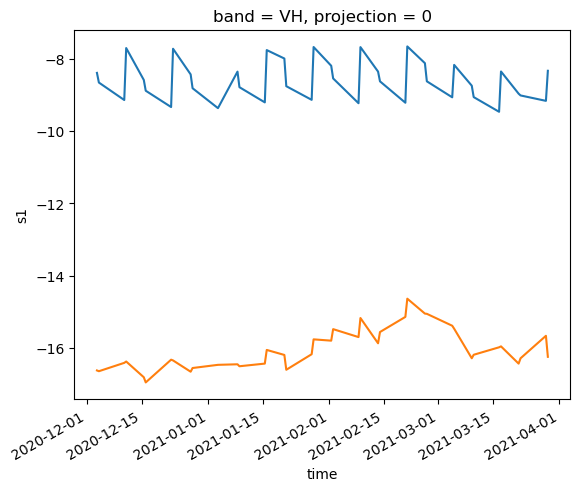

In [3]:
ds = dss['Little_Cottonwood_2021-03-18']
fig,ax = plt.subplots()
ds['s1'].sel(band = 'VV', time = slice('2020-12-01', None)).mean(['x','y']).plot(ax = ax)
ds['s1'].sel(band = 'VH', time = slice('2020-12-01', None)).mean(['x','y']).plot(ax = ax)

Text(0.5, 0.98, 'Normalized dVH and dVV backscatter changes\n Little Cottonwood 2020-12-03')

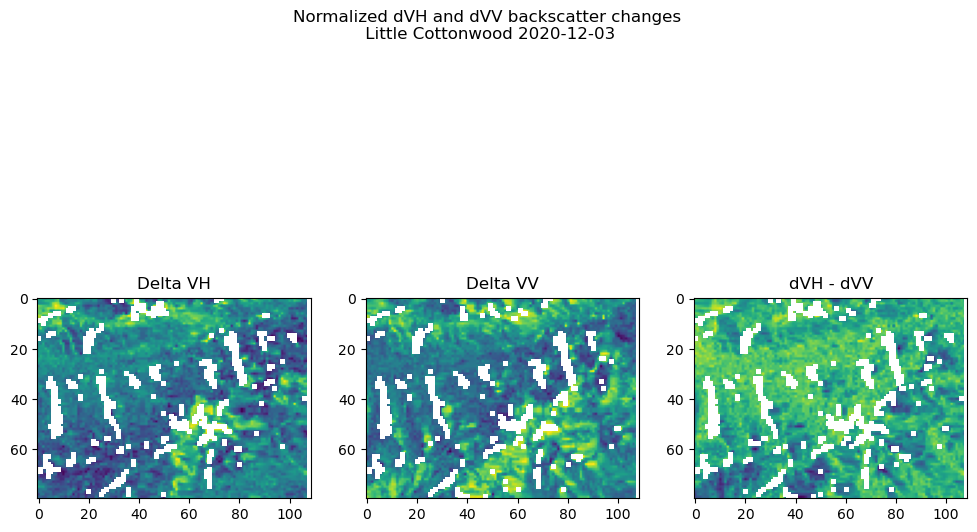

In [4]:
ds = dss['Little_Cottonwood_2021-03-18']

t = 41
fig,axes = plt.subplots(1, 3, figsize = (12, 8))

dvh = ds['s1'].sel(band = 'VH').diff(1).isel(time = t)
# Normalised [0,1]
def nan_ptp(a):
    return np.ptp(a[np.isfinite(a)])
dvh = dvh.data
dvh = (dvh - np.nanmin(dvh))/nan_ptp(dvh)
axes[0].imshow(dvh)
axes[0].set_title("Delta VH")

dvv = ds['s1'].sel(band = 'VV').diff(1).isel(time = t)
# Normalised [0,1]

dvv = dvv.data
dvv = (dvv - np.nanmin(dvv))/nan_ptp(dvv)
im = axes[1].imshow(dvv)
axes[1].set_title("Delta VV")

axes[2].imshow(dvh - dvv)
axes[2].set_title('dVH - dVV')
plt.suptitle(f'Normalized dVH and dVV backscatter changes\n Little Cottonwood {str(ds.isel(time = t).time.data).split("T")[0]}')
# plt.colorbar(im)
